# PyLipid Dual Cutoff Optimization

In [1]:
#Create folder to store PyLipid Optimization data
import os
try:
    os.mkdir("Analysis/PyLipid/Cut-Off_Optimization")
    print("Folder Analysis/PyLipid/Cut-Off_Optimization created")
except OSError as error:
    print("Can't create folder: folder Analysis/PyLipid/Cut-Off_Optimization already exists")

Can't create folder: folder Analysis/PyLipid/Cut-Off_Optimization already exists


In [6]:
#Prepare packages + Functions top determine minimum distances lipid-protein
from itertools import product
import mdtraj as md
from pylipid.util import get_traj_info, check_dir
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylipid
from pylipid.api import LipidInteraction
import matplotlib.ticker as ticker
import pickle
import shutil

def plot_minimum_distances(distances, times, title, fn):
    fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
    ax.plot(times, distances)
    ax.set_xlabel(r"Time ($\mu$s)")
    ax.set_ylabel("Minimum distances (nm)")
    ax.set_title(title)
    ax.set_ylim(0, 1.0)
    plt.tight_layout()
    plt.savefig(fn, dpi=200)
    plt.close()
    return


def compute_minimum_distance(traj, lipid, fig_dir, lipid_atoms=None,
                            contact_frames=10, distance_threshold=0.65):
    DIST_CONTACT_ALL = []
    traj_info, _, _ = get_traj_info(traj, lipid, lipid_atoms=lipid_atoms)
    for protein_idx in np.arange(nprot, dtype=int):
        for residue_idx, residue_atom_indices in enumerate(
            traj_info["protein_residue_atomid_list"][protein_idx]):
            dist_matrix = np.array([np.min(
                            md.compute_distances(traj, np.array(list(product(residue_atom_indices, lipid_atom_indices)))),
                            axis=1) for lipid_atom_indices in traj_info["lipid_residue_atomid_list"]])
            # plot distances
            for lipid_idx in np.arange(len(dist_matrix)):
                if sum(dist_matrix[lipid_idx] < distance_threshold) >= contact_frames:
                    DIST_CONTACT_ALL.append(dist_matrix[lipid_idx])
                    plot_minimum_distances(dist_matrix[lipid_idx], traj.time/1000000.0,
                                           "{}-{}{}".format(traj_info["residue_list"][residue_idx], lipid, lipid_idx),
                                           "{}/dist_{}_{}{}.png".format(fig_dir, traj_info["residue_list"][residue_idx],
                                                                        lipid, lipid_idx))

    return DIST_CONTACT_ALL

def plot_PDF(distance_set, num_of_bins, fn):
    fig, ax = plt.subplots(1,1)
    ax.hist(distance_set, bins=num_of_bins, density=True)
    ax.set_xlim(0, 1.0)
    ax.set_xlabel("Minimum distance (nm)")
    ax.set_ylabel("Probablity Density")
    ax.set_title(lipid)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    plt.tight_layout()
    plt.savefig(fn, dpi=200)
    return

def test_cutoffs(cutoff_list, trajfile_list, topfile_list, lipid, lipid_atons, nprot=1,
                 stride=1, save_dir=None, timeunit="us"):
    num_of_binding_sites = {}
    duration_avgs = {}
    num_of_contacting_residues = {}
    for cutoffs in cutoff_list:
        li = LipidInteraction(trajfile_list, topfile_list=topfile_list, cutoffs=cutoffs, lipid=lipid,
                              lipid_atoms=lipid_atoms, nprot=1, timeunit=timeunit,
                              save_dir=save_dir, stride=stride)
        li.collect_residue_contacts()
        li.compute_residue_duration()
        li.compute_binding_nodes(print_data=False) # switch print and write to False for cleaner output.
        num_of_binding_sites[cutoffs] = len(li.node_list)
        duration_avgs[cutoffs] = li.dataset["Duration"].mean()
        num_of_contacting_residues[cutoffs] = sum(li.dataset["Duration"]>0)
    shutil.rmtree(li.save_dir)
    return num_of_binding_sites, duration_avgs, num_of_contacting_residues

def graph(cutoff_list, metric_values, ylabel, title, fn):
    fig, ax = plt.subplots(1, 1, figsize=(len(cutoff_list)*0.42, 3.6))
    ax.scatter(np.arange(len(cutoff_list)), metric_values, s=50, color='red')
    ax.set_xticks(np.arange(len(cutoff_list)))
    ax.set_xticklabels(cutoff_list, rotation=45, ha='right')
    ax.set_xlabel("Dual cutoff")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(fn, dpi=200)
    return

Can't create folder: folder Analysis/PyLipid/Cut-Off_Optimization/POPI already exists


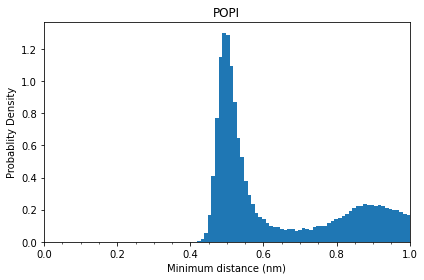

In [11]:
trajfile = "../Sample_files/centered_step7_1.xtc"
topfile = "../Sample_files/step6.6_equilibration.gro"
lipids = {"POPI":"C1 C2 C3 PO4"} #Define lipids and head atoms
nprot = 1 #Single protein per system
timeunit = "us"
stride = 10


contact_frames = 30  # will only plot data if the contact was formed over ${contact_frames} frames.
distance_threshold = 0.65 #Distance to consider contact

traj = md.load(trajfile, top=topfile, stride=10)

for lipid, headatoms in lipids.items():
    try:
        os.mkdir(f"Analysis/PyLipid/Cut-Off_Optimization/{lipid}")
        print(f"Folder Analysis/PyLipid/Cut-Off_Optimization/{lipid} created")
    except OSError as error:
        print(f"Can't create folder: folder Analysis/PyLipid/Cut-Off_Optimization/{lipid} already exists")
    
    lipid_atoms = headatoms
    
    save_dir = f"Analysis/PyLipid/Cut-Off_Optimization/{lipid}/test_minimum_dist_{lipid}"
    fig_dir = check_dir(save_dir, "Figures", print_info=False)
    minimum_distance_set = compute_minimum_distance(traj, lipid, fig_dir, lipid_atoms=lipid_atoms,
                                               contact_frames=contact_frames, distance_threshold=distance_threshold)
    distance_set = np.concatenate(minimum_distance_set)
    num_of_bins = 1000
    fig_fn = f"{save_dir}/dist_distribut_{lipid}.png"
    plot_PDF(distance_set, num_of_bins, fig_fn)

Creating new director: /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts/Analysis/PyLipid/Cut-Off_Optimization/POPI/test_minimum_dist_POPI/test_cutoffs/Interaction_POPI


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1188.25it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1461.58it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1238.81it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1380.40it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1254.01it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1454.43it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1479.74it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1456.98it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1372.37it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1392.24it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1390.14it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1370.76it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1369.73it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1378.30it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1366.99it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1368.58it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1306.49it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1455.56it/s]


******************************
 No binding site detected!!
******************************


CALCULATE DURATION PER RESIDUE: 100%|█████| 1482/1482 [00:01<00:00, 1236.12it/s]


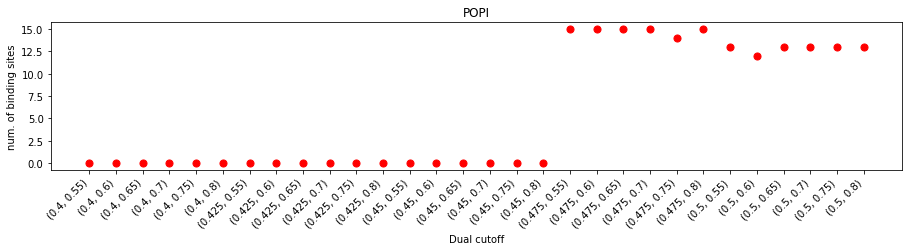

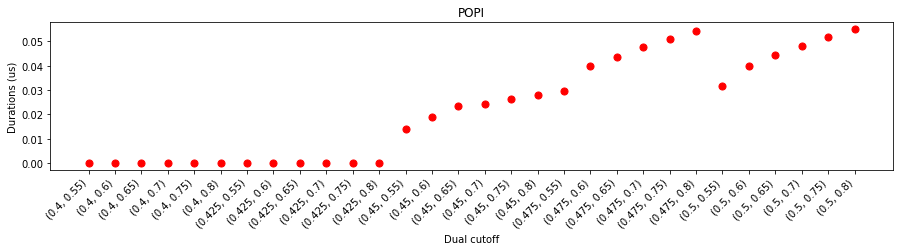

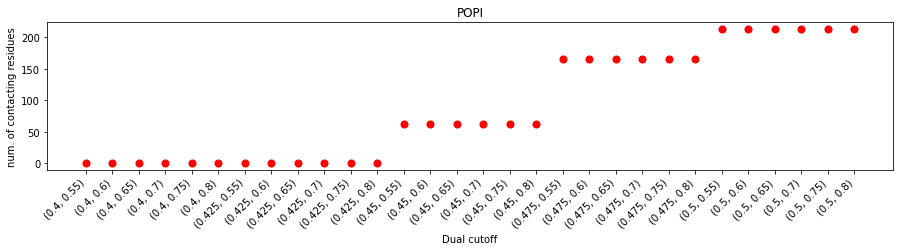

In [12]:
# Check 
lower_cutoff = [0.40, 0.425, 0.45, 0.475, 0.5]
upper_cutoff = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
cutoff_list = list(product(lower_cutoff, upper_cutoff))
stride = 100

for lipid, lipidatoms in lipids.items():
    save_dir = f"Analysis/PyLipid/Cut-Off_Optimization/{lipid}/test_minimum_dist_{lipid}/test_cutoffs"
    
    num_of_binding_sites, duration_avgs, num_of_contacting_residues = test_cutoffs(
                                     cutoff_list, trajfile, topfile, lipid, lipidatoms,
                                     nprot=nprot, stride=stride, save_dir=save_dir, timeunit=timeunit)


    test_data = {"num_of_binding_sites": num_of_binding_sites,
                 "duration_avgs": duration_avgs,
                 "num_of_contacting_residues": num_of_contacting_residues,
                 "test_cutoff_list": cutoff_list}

    with open(f"{save_dir}/test_cutoff_data_{lipid}.pickle", "wb") as f:
        pickle.dump(test_data, f, 2)

    graph(cutoff_list, [num_of_binding_sites[cutoffs] for cutoffs in cutoff_list],
          "num. of binding sites", lipid, f"{save_dir}/test_cutoff_num_of_bs_{lipid}.png")

    graph(cutoff_list, [duration_avgs[cutoffs] for cutoffs in cutoff_list],
          f"Durations ({timeunit})", lipid, f"{save_dir}/test_cutoff_durations_{lipid}.png")

    graph(cutoff_list, [num_of_contacting_residues[cutoffs] for cutoffs in cutoff_list],
          "num. of contacting residues", lipid,
          f"{save_dir}/test_cutoff_num_of_contacting_residues_{lipid}.png")